# Online non-linear SDEs

In [1]:
import jax
import flax.linen as nn
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt

from rebayes_mini.methods.gauss_filter import GaussianFilter
from rebayes_mini.methods.adaptive import ExpfamRLPR

In [296]:
plt.rcParams["font.size"] = 12

In [2]:
key = jax.random.PRNGKey(3141)

In [3]:
%config InlineBackend.figure_format = "retina"
sns.set_palette("colorblind")

In [505]:
sigma = 1.0
kappa = 0.8
dt = 0.01
y_bar = 100.0
p_change = 0.001
mu = 0.005

In [506]:
def step(state, key):
    y, choice_prev = state
    key_choice, key_change, key_err = jax.random.split(key, 3)
    is_change = jax.random.bernoulli(key_change, p_change)
    choice = jax.random.choice(key_choice, 3)

    choice_next = choice_prev * (1 - is_change) + choice * is_change

    mu_next = (
        kappa * (y_bar - y) * (choice_next == 0) +
        mu * y * (choice_next == 0) +
        -mu * y * (choice_next == 1)
    )

    Z_next = jax.random.normal(key_err)

    y_next = y + mu_next * dt + sigma * jnp.sqrt(dt) * Z_next
    
    return (y_next, choice_next), (y_next, choice_next)

In [508]:
key = jax.random.PRNGKey(314)
steps = 5_000
keys = jax.random.split(key, steps)
state_init = (100.0, 0)
_, (y_hist, choice_hist) = jax.lax.scan(step, state_init, keys)

In [509]:
key_train = jax.random.PRNGKey(314)

In [510]:
def callback(bel, bel_pred, y, X):
    yhat = jax.vmap(base_filter.link_fn, in_axes=(0, None))(bel.mean, X)
    res = {
        "runlength": bel.runlength,
        "log_posterior": bel.log_joint - jax.nn.logsumexp(bel.log_joint),
        "yhat": yhat,
        "mean": bel.mean
    }
    
    return res

In [511]:
class NNet(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(1)(x)
        return x

In [512]:
model = NNet()
params_init = model.init(key_train, y_hist[:, None])
params_init = jax.tree.map(lambda x: x * 0.0, params_init)

In [513]:
partitions = jnp.where(jnp.abs(jnp.diff(choice_hist + 1)) > 0)[0]
partitions = jnp.insert(partitions, 0, 0)
partitions = jnp.insert(partitions, steps - 1, steps-1)

colors = sns.color_palette("Dark2", n_colors=3)
colors = [colors[p] for p in choice_hist[partitions[1:]]]

In [514]:
diff_hist = jnp.diff(y_hist)
base_filter = GaussianFilter(model.apply, dynamics_covariance=0.0, variance=dt)
agent = ExpfamRLPR(p_change, K=1, filter=base_filter)
bel_init = agent.init_bel(params_init, 0.02, 0.0)
bel_init = bel_init.replace(mean=bel_init.mean.at[:, 0].set(0.0))

X = y_hist[1:, None]
bel_final, hist = agent.scan(diff_hist[:, None], X, bel_init, callback)

In [515]:
posterior = jnp.exp(hist["log_posterior"])

In [516]:
yhat_vals = (hist["yhat"][..., 0] * posterior).sum(axis=1)
# yhat_vals = y_hist[1:] + yhat_vals
# yhat_vals = jnp.insert(yhat_vals, 0, 100.0, axis=0).squeeze()
# yhat_vals = yhat_vals.cumsum(axis=0)

(-0.46469879150390625, 0.3134918212890625)

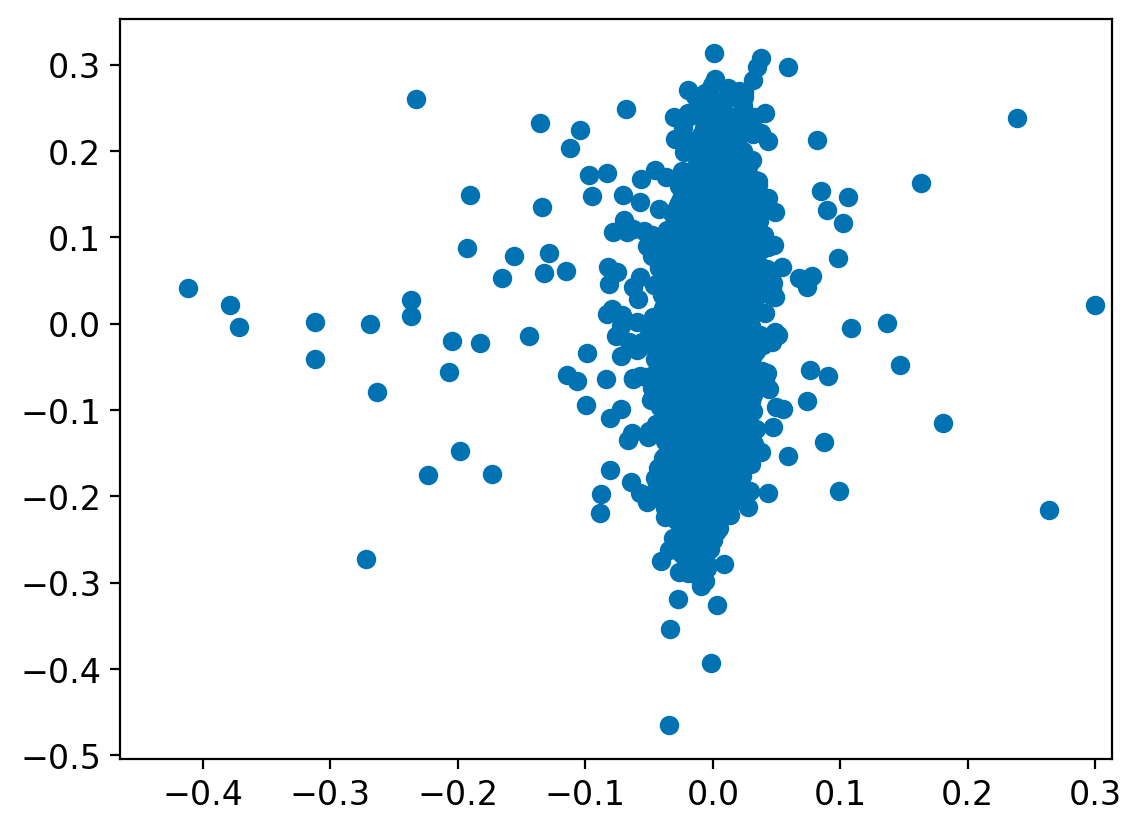

In [517]:
plt.scatter(yhat_vals, diff_hist[:, None])
plt.xlim(diff_hist.min(), diff_hist.max())

In [518]:
bel_final.mean

Array([[-0.00835134, -0.00012206]], dtype=float32)

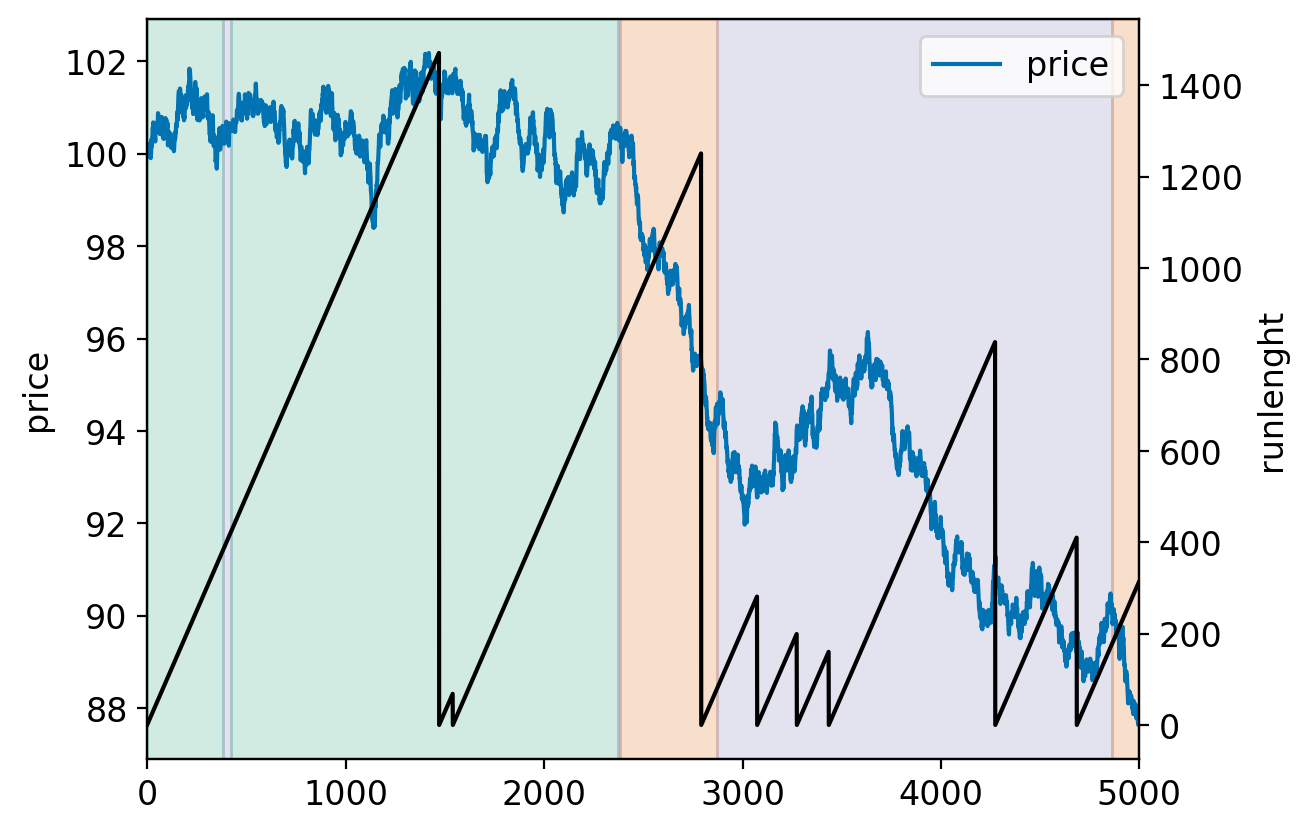

In [519]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
time = -1

for c, ix_init, ix_end in zip(colors, partitions[:-1], partitions[1:]):
    ax.axvspan(ix_init, ix_end, color=c, alpha=0.2)
# ax.plot(choice_hist)
ax.plot(y_hist[:time], label="price")

ax2.plot((posterior * hist["runlength"]).sum(axis=1)[:time], c="black")
ax.legend()
ax.set_ylabel("price")
ax2.set_ylabel("runlenght")
plt.xlim(0, steps);

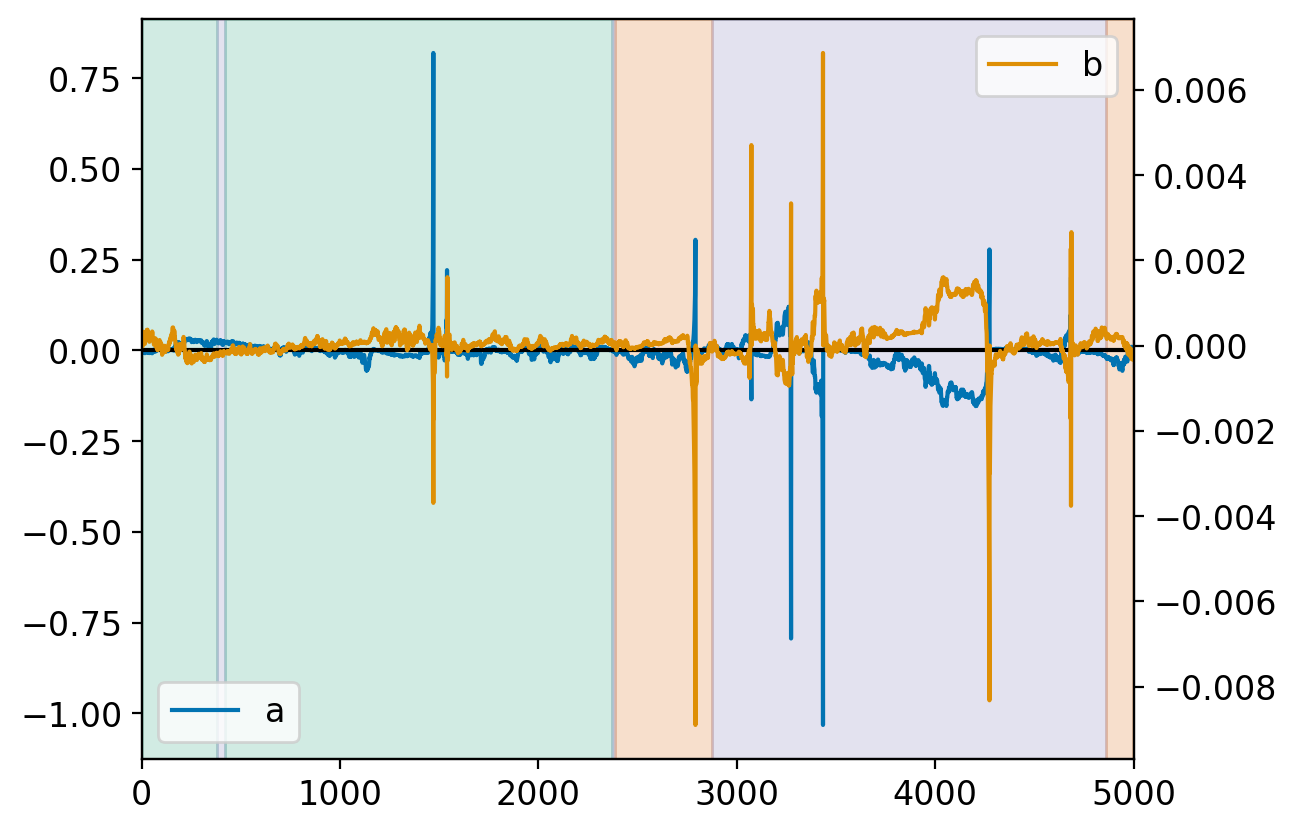

In [520]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(hist["mean"].squeeze()[:, 0], label="a")
ax2.plot(hist["mean"].squeeze()[:, 1], label="b", c=sns.color_palette()[1])

ax2.legend(loc="upper right")
ax.legend(loc="lower left")

# ax.set_yscale("symlog")
ax.axhline(y=0.0, c="black")
# ax2.plot(choice_hist, c="black")
# ax2.plot((posterior * hist["runlength"]).sum(axis=1)[:time], c="black")

for c, ix_init, ix_end in zip(colors, partitions[:-1], partitions[1:]):
    ax.axvspan(ix_init, ix_end, color=c, alpha=0.2)
plt.xlim(0, steps);